In [1]:
import requests
import json
import pandas as pd
import numpy as np
# import dotenv
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix, classification_report, precision_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from datetime import datetime,timedelta

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')

In [2]:
carparks_df = pd.read_parquet('data/carpark_history_6_months_zones_coords.parquet')
carparks_df.head()

ArrowMemoryError: malloc of size 134217728 failed

In [5]:
carparks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2924545 entries, 0 to 2924544
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   tsn                   int32  
 1   time                  int32  
 2   spots_x               int32  
 3   zones                 object 
 4   ParkID                int32  
 5   occupancy             object 
 6   MessageDate           object 
 7   facility_id           int32  
 8   facility_name         object 
 9   tfnsw_facility_id     object 
 10  parent_zone_id        object 
 11  spots_y               int32  
 12  zone_id               int32  
 13  zone_name             object 
 14  occupancy.loop        object 
 15  occupancy.monthlies   object 
 16  occupancy.open_gate   object 
 17  occupancy.total       int32  
 18  occupancy.transients  object 
 19  longitude             float64
 20  latitude              float64
dtypes: float64(2), int32(8), object(11)
memory usage: 379.3+ MB


In [6]:
df1 = carparks_df[['facility_id','facility_name','spots_x',  'occupancy.total',
                   'MessageDate','longitude','latitude' ]]

# Renaming the spots column to something more intuitive
df1.rename(columns={'spots_x': 'capacity'}, inplace=True)
df1.rename(columns={'occupancy.total': 'occupancy'}, inplace=True)


df1.head()

,facility_id,facility_name,capacity,occupancy,MessageDate,longitude,latitude
0,6,Gordon Henry St North Car Park,213,31,2023-07-01T00:01:02,-33.756009,151.154528
1,6,Gordon Henry St North Car Park,213,30,2023-07-01T00:21:32,-33.756009,151.154528
2,6,Gordon Henry St North Car Park,213,31,2023-07-01T05:36:31,-33.756009,151.154528
3,6,Gordon Henry St North Car Park,213,32,2023-07-01T05:51:02,-33.756009,151.154528
4,6,Gordon Henry St North Car Park,213,33,2023-07-01T07:03:16,-33.756009,151.154528


### FEATURE ENGINEERING

In [7]:
df1['parking_availability'] = df1['capacity'] - df1['occupancy']
df1.head()

,facility_id,facility_name,capacity,occupancy,MessageDate,longitude,latitude,parking_availability
0,6,Gordon Henry St North Car Park,213,31,2023-07-01T00:01:02,-33.756009,151.154528,182
1,6,Gordon Henry St North Car Park,213,30,2023-07-01T00:21:32,-33.756009,151.154528,183
2,6,Gordon Henry St North Car Park,213,31,2023-07-01T05:36:31,-33.756009,151.154528,182
3,6,Gordon Henry St North Car Park,213,32,2023-07-01T05:51:02,-33.756009,151.154528,181
4,6,Gordon Henry St North Car Park,213,33,2023-07-01T07:03:16,-33.756009,151.154528,180


In [8]:
# Split the datetime string into date and time components
df1[['Date', 'Time']] = df1['MessageDate'].str.split('T', expand=True)

# Display the DataFrame with the new 'Date' and 'Time' columns
df1.head()


,facility_id,facility_name,capacity,occupancy,MessageDate,longitude,latitude,parking_availability,Date,Time
0,6,Gordon Henry St North Car Park,213,31,2023-07-01T00:01:02,-33.756009,151.154528,182,2023-07-01,00:01:02
1,6,Gordon Henry St North Car Park,213,30,2023-07-01T00:21:32,-33.756009,151.154528,183,2023-07-01,00:21:32
2,6,Gordon Henry St North Car Park,213,31,2023-07-01T05:36:31,-33.756009,151.154528,182,2023-07-01,05:36:31
3,6,Gordon Henry St North Car Park,213,32,2023-07-01T05:51:02,-33.756009,151.154528,181,2023-07-01,05:51:02
4,6,Gordon Henry St North Car Park,213,33,2023-07-01T07:03:16,-33.756009,151.154528,180,2023-07-01,07:03:16


In [9]:
# def extract_date_time(message_date):
#   date = message_date.split('T')[0]
#   time = message_date.split('T')[1]
#   return date,time

# Define time categories
def categorize_time(hour):
    if 4 <= hour < 7:
        return 'Early Morning'
    elif 7 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 15:
        return 'Afternoon'
    elif 15 <= hour < 18:
        return 'Late Afternoon'
    elif 18 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'


# # Separate the date and time in to 2 separate columns
# df1[['date','time']] = df1['MessageDate'].apply(extract_date_time).apply(pd.Series)



In [10]:
# # Separate the Date
# and Time into two separate columns
# df1[['Date
#', 'Time']] = df1['MessageDate'].str.split('T', expand=True)

# Indicate the day of the week according to the Date
df1['day_of_week'] = pd.to_datetime(df1['Date']).dt.day_name()

# Convert the 'Time' column to timedelta object
df1['Time'] = pd.to_datetime(df1['Time'])

# Extract the hour component
df1['hour'] = pd.to_datetime(df1['Time']).dt.hour

# Create a new column 'time_category'
df1['time_category'] = df1['hour'].apply(categorize_time)

# Convert 'Date
#' column to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])

# Extract month name from the 'Date
#' column and assign it to a new 'month' column
df1['month'] = df1['Date'].dt.strftime('%B')

# Convert 'Time' column to Time object
df1['Time'] = pd.to_datetime(df1['Time']).dt.time

# Drop unnecessary columns
df1.drop(['hour'], axis=1, inplace=True)

# Display the DataFrame with the new 'month' column
df1.head()


,facility_id,facility_name,capacity,occupancy,MessageDate,longitude,latitude,parking_availability,Date,Time,day_of_week,time_category,month
0,6,Gordon Henry St North Car Park,213,31,2023-07-01T00:01:02,-33.756009,151.154528,182,2023-07-01,00:01:02,Saturday,Night,July
1,6,Gordon Henry St North Car Park,213,30,2023-07-01T00:21:32,-33.756009,151.154528,183,2023-07-01,00:21:32,Saturday,Night,July
2,6,Gordon Henry St North Car Park,213,31,2023-07-01T05:36:31,-33.756009,151.154528,182,2023-07-01,05:36:31,Saturday,Early Morning,July
3,6,Gordon Henry St North Car Park,213,32,2023-07-01T05:51:02,-33.756009,151.154528,181,2023-07-01,05:51:02,Saturday,Early Morning,July
4,6,Gordon Henry St North Car Park,213,33,2023-07-01T07:03:16,-33.756009,151.154528,180,2023-07-01,07:03:16,Saturday,Morning,July


In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2924545 entries, 0 to 2924544
Data columns (total 13 columns):
 #   Column                Dtype         
---  ------                -----         
 0   facility_id           int32         
 1   facility_name         object        
 2   capacity              int32         
 3   occupancy             int32         
 4   MessageDate           object        
 5   longitude             float64       
 6   latitude              float64       
 7   parking_availability  int32         
 8   Date                  datetime64[ns]
 9   Time                  object        
 10  day_of_week           object        
 11  time_category         object        
 12  month                 object        
dtypes: datetime64[ns](1), float64(2), int32(4), object(6)
memory usage: 245.4+ MB


In [14]:
final_df = df1.copy()
# Read holiday information DataFrame
holiday_data = pd.read_csv('data/NSW_holidays_2023.csv')

# Convert 'Date' column to datetime format
holiday_data['Date'] = pd.to_datetime(holiday_data['Date'], format='%b %d')

# Extract month and day information and format it as 'Month Day' in holiday_data
holiday_data['month_day'] = holiday_data['Date'].dt.strftime('%m-%d')

# Create a set of holiday month-day combinations
holidays_month_day = set(holiday_data['month_day'])

# Check if the month-day combination of each Date in df1 matches any holiday month-day combination
final_df['month_day'] = final_df['Date'].dt.strftime('%m-%d')
final_df['is_holiday'] = final_df['month_day'].isin(holidays_month_day)

# Map True/False to 'yes'/'no' for 'is_holiday' column
final_df['is_holiday'] = final_df['is_holiday'].map({True: 'Yes', False: 'No'})

# Drop the temporary 'month_day' column
final_df.drop(columns=['month_day'], inplace=True)

# Display the DataFrame to verify changes
final_df.head()

,facility_id,facility_name,capacity,occupancy,MessageDate,longitude,latitude,parking_availability,Date,Time,day_of_week,time_category,month,is_holiday
0,6,Gordon Henry St North Car Park,213,31,2023-07-01T00:01:02,-33.756009,151.154528,182,2023-07-01,00:01:02,Saturday,Night,July,No
1,6,Gordon Henry St North Car Park,213,30,2023-07-01T00:21:32,-33.756009,151.154528,183,2023-07-01,00:21:32,Saturday,Night,July,No
2,6,Gordon Henry St North Car Park,213,31,2023-07-01T05:36:31,-33.756009,151.154528,182,2023-07-01,05:36:31,Saturday,Early Morning,July,No
3,6,Gordon Henry St North Car Park,213,32,2023-07-01T05:51:02,-33.756009,151.154528,181,2023-07-01,05:51:02,Saturday,Early Morning,July,No
4,6,Gordon Henry St North Car Park,213,33,2023-07-01T07:03:16,-33.756009,151.154528,180,2023-07-01,07:03:16,Saturday,Morning,July,No


In [36]:
final_df = final_df.drop("Month", axis = 1)
final_df.head()

,facility_id,facility_name,capacity,occupancy,longitude,latitude,parking_availability,Date,Time,day_of_week,time_category,month,is_holiday
0,6,Gordon Henry St North Car Park,213,31,-33.756009,151.154528,182,2023-07-01,00:01:02,Saturday,Night,July,No
1,6,Gordon Henry St North Car Park,213,30,-33.756009,151.154528,183,2023-07-01,00:21:32,Saturday,Night,July,No
2,6,Gordon Henry St North Car Park,213,31,-33.756009,151.154528,182,2023-07-01,05:36:31,Saturday,Early Morning,July,No
3,6,Gordon Henry St North Car Park,213,32,-33.756009,151.154528,181,2023-07-01,05:51:02,Saturday,Early Morning,July,No
4,6,Gordon Henry St North Car Park,213,33,-33.756009,151.154528,180,2023-07-01,07:03:16,Saturday,Morning,July,No


In [37]:
final_df.columns

Index(['facility_id', 'facility_name', 'capacity', 'occupancy', 'longitude',
       'latitude', 'parking_availability', 'Date', 'Time', 'day_of_week',
       'time_category', 'month', 'is_holiday'],
      dtype='object')

In [26]:
final_df.is_holiday.value_counts()

No     2884311
Yes      40234
Name: is_holiday, dtype: int64

In [18]:
# Assuming your DataFrame is named df
final_df.to_parquet('data/final_dataset.parquet')

In [20]:
print(f'Number of unique Parking Facilities:', final_df.facility_name.nunique())
print(f'Number of unique days:', final_df.Date.nunique())

Number of unique Parking Facilities: 28
Number of unique days: 184


## EXPLORATORY DATA ANALYSIS

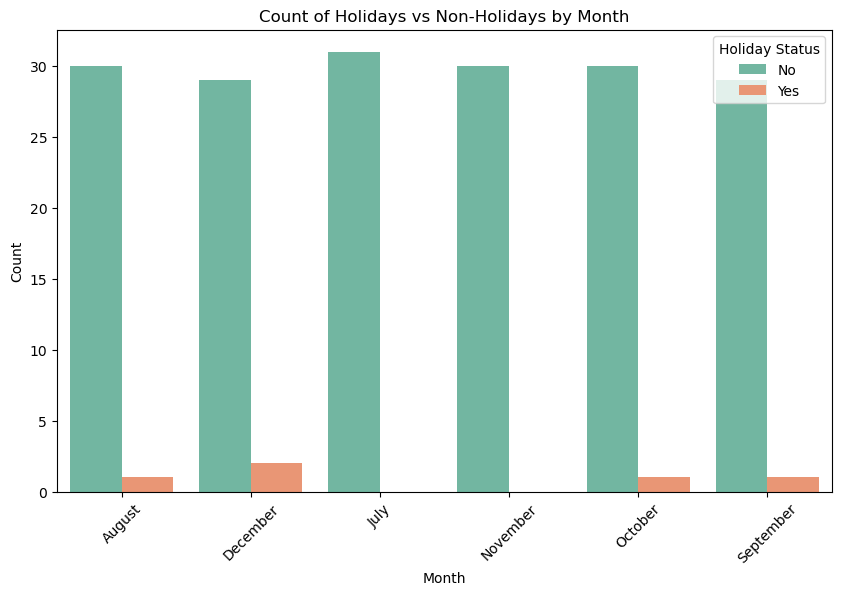

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by 'Month' and 'is_holiday' columns and count the occurrences
holiday_counts = final_df.groupby(['month', 'is_holiday'])['Date'].nunique().reset_index(name='Count')

# Create a countplot
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='Count', hue='is_holiday', data=holiday_counts, palette='Set2')
plt.title('Count of Holidays vs Non-Holidays by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Holiday Status')
plt.show()


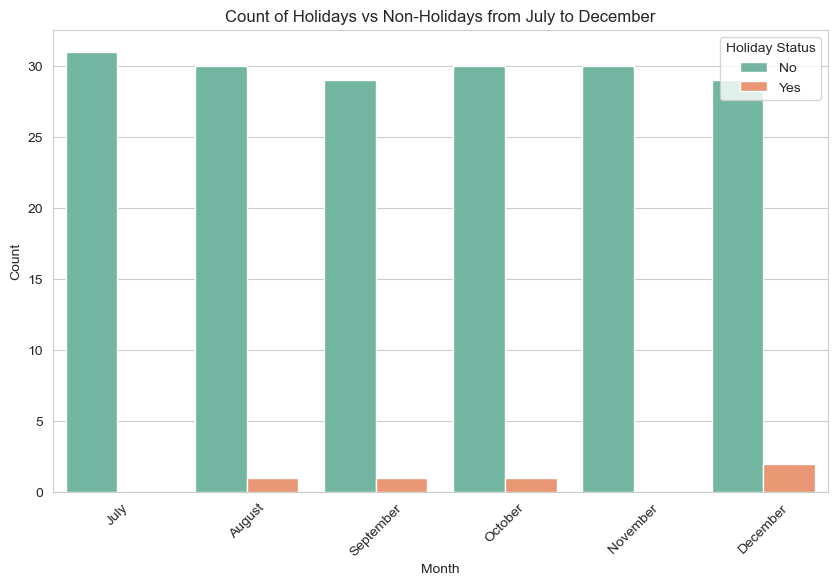

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order of months from July to December
month_order = ['July', 'August', 'September', 'October', 'November', 'December']

# Convert 'month' column to categorical with specified order
final_df['month'] = pd.Categorical(final_df['month'], categories=month_order, ordered=True)

# Group by 'Month' and 'is_holiday' columns and count the occurrences
holiday_counts = final_df.groupby(['month', 'is_holiday'])['Date'].nunique().reset_index(name='Count')

# Create a countplot
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='Count', hue='is_holiday', data=holiday_counts, palette='Set2')
plt.title('Count of Holidays vs Non-Holidays from July to December')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Holiday Status')
plt.show()


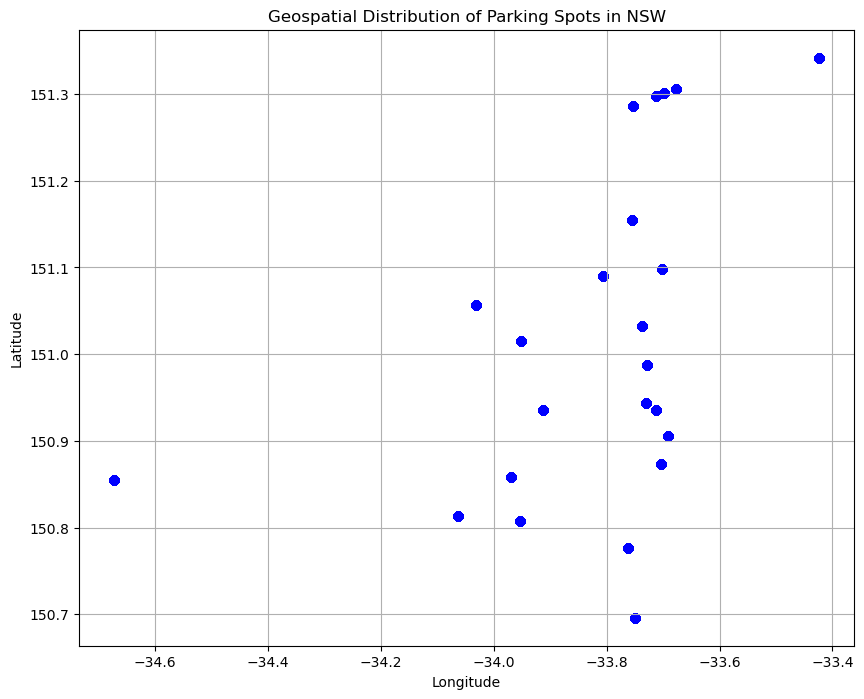

In [50]:
import matplotlib.pyplot as plt

# Filter out rows with NaN values in latitude and longitude columns
nsw_parking_spots = final_df.dropna(subset=['latitude', 'longitude'])

# Check if there are any rows left after filtering
if not nsw_parking_spots.empty:
    # Create a scatter plot of longitude vs latitude
    plt.figure(figsize=(10, 8))
    plt.scatter(nsw_parking_spots['longitude'], nsw_parking_spots['latitude'], marker='o', color='blue', alpha=0.5)
    
    # Customize the plot
    plt.title('Geospatial Distribution of Parking Spots in NSW')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    
    # Show the plot
    plt.show()
else:
    print("No valid parking spots found with longitude and latitude information.")


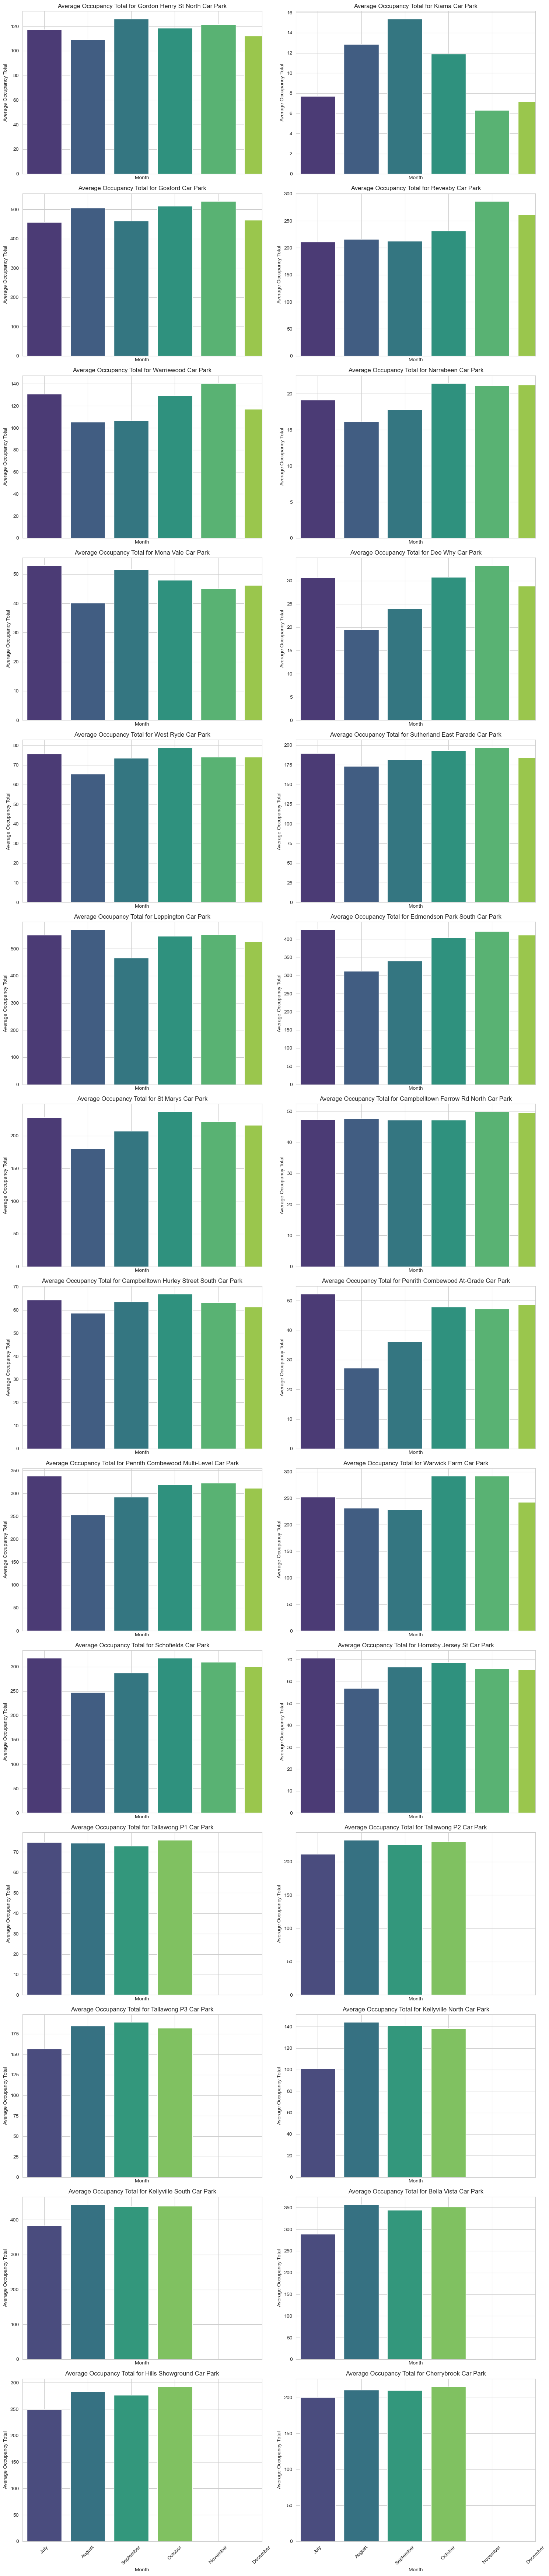

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of unique facility names
facility_names = final_df['facility_name'].unique()

# Calculate the number of rows and columns for the subplot grid
num_rows = len(facility_names) // 2 + len(facility_names) % 2  # Round up for odd number of plots
num_cols = 2

# Set the style of the plot
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows), sharex=True)

# Flatten the axes array if necessary
if num_rows > 1:
    axes = axes.flatten()

# Iterate over each facility name and corresponding subplot
for i, (facility_name, ax) in enumerate(zip(facility_names, axes)):
    # Filter data for the current facility
    facility_data = final_df[final_df['facility_name'] == facility_name]
    
    # Group the data by month and calculate the average occupancy total
    facility_month_avg = facility_data.groupby('month')['occupancy'].mean().reset_index()
    
    # Create bar plot for the current facility
    sns.barplot(data=facility_month_avg, x='month', y='occupancy', palette='viridis', ax=ax)
    
    # Set title and labels for the current subplot
    ax.set_title(f'Average Occupancy Total for {facility_name}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Average Occupancy Total')
    ax.set_xticks(range(6))
    ax.set_xticklabels(['July', 'August', 'September', 'October', 'November', 'December'], rotation=45)
    ax.tick_params(axis='x', labelrotation=45)
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


In [51]:
import folium

# Filter out rows with NaN values in latitude and longitude columns
nsw_parking_spots = final_df.dropna(subset=['latitude', 'longitude'])

# Check if there are any rows left after filtering
if not nsw_parking_spots.empty:
    # Create a map centered at the mean latitude and longitude of NSW
    m = folium.Map(location=[nsw_parking_spots['latitude'].mean(), nsw_parking_spots['longitude'].mean()], zoom_start=8)
    
    # Add markers for each parking spot in NSW
    for idx, row in nsw_parking_spots.iterrows():
        popup_text = f"{row['facility_name']}"  # Customize popup text
        folium.Marker(location=[row['latitude'], row['longitude']], popup=popup_text).add_to(m)
    
    # Display the map
    m
else:
    print("No valid parking spots found with longitude and latitude information.")


### Scatter Plots
In summary, the code provides a visual representation of how the selected columns relate to the 'parking_availability' column through scatter plots in a 1x2 grid. The scatter plots visualize the potential relationships or patterns between the features (total_parking_spots and occupancy_total) and the target variable, parking_availability.

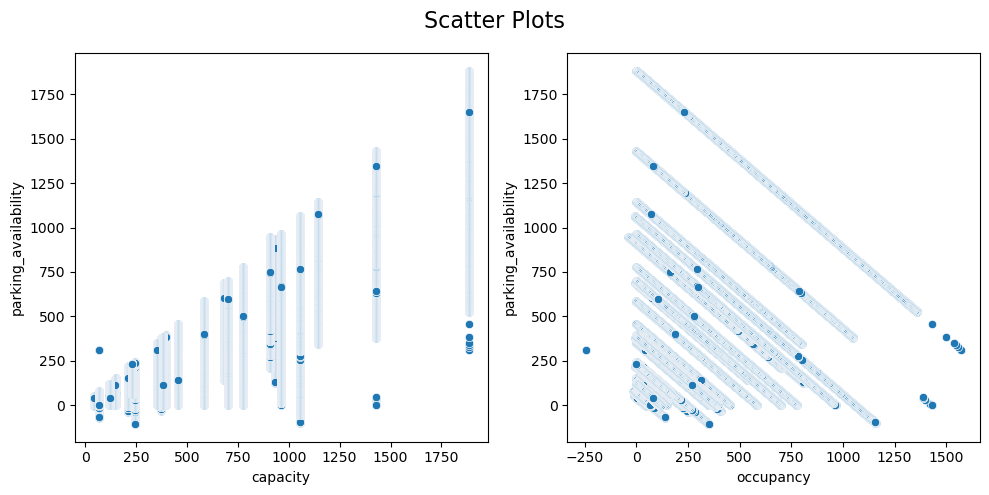

In [32]:
# Setting the target column
target_column = "parking_availability"

# List of columns to create scatterplots for
columns_to_plot = ['capacity', 'occupancy']

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Scatter Plots', fontsize=16)

# Create scatterplots for each selected column against the target using Seaborn
for i, column in enumerate(columns_to_plot):
    sns.scatterplot(x=column, y=target_column, data=final_df, ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel(target_column)

# Remove any extra empty subplot if the number of categories is odd
if len(columns_to_plot) % 2 == 1:
    fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()

### Correlation Heatmap
This heatmap visually represents the correlation between the numeric columns in your DataFrame.. The color intensity and the annotation values provide insights into the strength and direction of the correlation.

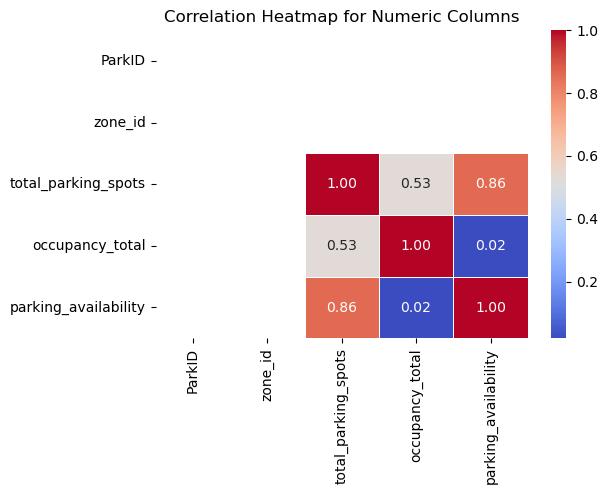

In [ ]:
# Filter only numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

# Create a correlation matrix
correlation_matrix = numeric_columns.corr()

# Set up the matplotlib figure
plt.figure(figsize=(6, 4))
# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
# Set the title
plt.title('Correlation Heatmap for Numeric Columns')

# Show the plot
plt.show()

In [ ]:

# Define the target column and the features

y = df.parking_availability
X = df.drop(['parking_availability', 'ParkID','zone_id', 'time'], axis = 1)

# Split the data into test and train samples, with a random state of 121 for reproducability and test size of 30%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state = 121)
X_train

,facility_name,total_parking_spots,occupancy_total,day_of_week,date
286839,Tallawong P3 Car Park,397,210,Friday,2023-12-15
168689,Penrith Combewood Multi-Level Car Park,1144,552,Thursday,2023-12-14
367518,Bella Vista Car Park,777,191,Sunday,2023-12-17
372557,Bella Vista Car Park,777,592,Thursday,2023-12-21
20003,Dee Why Car Park,117,6,Tuesday,2023-12-12
...,...,...,...,...,...
444504,Gordon Henry St North Car Park,213,207,Thursday,2023-12-07
224768,Schofields Car Park,700,0,Thursday,2023-12-28
318747,Kellyville South Car Park,964,587,Monday,2023-12-11
365032,Bella Vista Car Park,777,476,Friday,2023-12-15


In [ ]:
# Function to create the model
def create_pipeline(steps):
    category_features_encoded = ColumnTransformer(transformers=[
            ("ohe", OneHotEncoder(categories="auto", drop='if_binary', sparse=False),
            ['facility_name', 'day_of_week', 'date'])
        ], remainder="passthrough")

    # Create a pipeline
    pipe = Pipeline(steps)
    return pipe

def fit_and_score(X_train, X_test, pipe):
    pipe.fit(X_train, y_train)
    y_predict = pipe.predict(X_test)
    y_train_predict = pipe.predict(X_train)
    pipe.score(X_test, y_test)

    print("\n-------------------Training Evaluation-------------------\n",
           classification_report(y_train, y_train_predict))
    print("-------------------Testing Evaluation-------------------\n",
           classification_report(y_test, y_predict))
  
    # Check the AUC for training predictions
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_train_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print('\nTraining AUC is :{0}'.format(round(roc_auc, 3)))

    # Check the AUC for testing predictions
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print('Testing AUC is :{0}'.format(round(roc_auc, 3)))

    # Create and print a confusion matrix 
    print('\n\n----------Testing Data Confusion Matrix-----------')
    cm = confusion_matrix(y_test, y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.grid(False)
    plt.show();


In [ ]:
category_features_encoded = ColumnTransformer(transformers=[
            ("ohe", OneHotEncoder(categories="auto", drop='if_binary', sparse=False),
            ['facility_name', 'day_of_week', 'date'])
        ], remainder="passthrough")

steps_base = [
            ("encoded_features", category_features_encoded),
            ("scale", MinMaxScaler()),
            ("classifier", LogisticRegression(fit_intercept= False, C=1e12, solver='liblinear', random_state=121))
        ]

# Creating fitting and evaluating the model
pipe_base = create_pipeline(steps_base)
fit_and_score(X_train, X_test, pipe_base)

c:\Users\DELL\anaconda3\envs\project-env\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
